In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

seq_length = 1

def sort(batch):
    return np.sort(batch)

def reverse(batch):
    return np.flip(batch, axis=1)

def copy(batch):
    return batch

def decimal2binary(data, vec_dim):
    out = []
    for i in data:
        out.append([int(s) for s in list(bin(i)[2:].zfill(vec_dim))])
    return out 

def binary2decimal(data):
    bd = len(data[0])
    twos = []
    for i in range(1, bd+1):
        twos.append(2**(bd-i))
    twos = np.array(twos)
    return np.sum(data*twos, axis=-1)

def binary2decimal_batch(batch):
    batch_size, seq_length, vec_dim = batch.shape
    twos = tf.reshape(2**(vec_dim - 1 - tf.range(0, vec_dim, 1.0)), shape=(1, 1, vec_dim))
    twos_batch = tf.tile(twos, tf.constant([batch_size, seq_length, 1], tf.int32))
    return tf.reduce_sum(batch*twos_batch, axis=2)

def random_X(seq_length=4, vec_dim=4):
    return [[0]+np.random.choice([0, 1], vec_dim).tolist() for i in range(seq_length)]

def get_Z_corresponding_to(X):
    batch_size, seq_length, vec_dim = X.shape
    #print(X.shape)
    Z = tf.concat([tf.reshape(tf.tile(tf.eye(vec_dim)[0], 
                                      #tf.ones(vec_dim), 
                                      tf.constant([batch_size], tf.int32)), 
                                     (batch_size, 1,            vec_dim)), 
                      tf.zeros(shape=(batch_size, seq_length-1, vec_dim))], axis=1)
    return Z

def get_XY(seq_length=4, vec_dim=4, size=100, f=sort):
    X = [random_X(seq_length, vec_dim) for _ in range(size)]
    Y = [decimal2binary(f([binary2decimal(x)])[0], vec_dim) for x in X]
    return X, Y

def get_binary_dataset(seq_length=4, vec_dim=4, size=100, f=reverse):
    X, Y = get_XY(seq_length, vec_dim, size, f=f)
    X = np.array(X).astype(np.float32)
    Y = np.array(Y).astype(np.float32)
    return tf.data.Dataset.from_tensor_slices((X, Y))

def loss_sum(y, z):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=z, name=None))

def update(X, Y, model, optimizer): # 学習ステップ
    batch_size = X.shape[0]
    init_h = model.reset_states(batch_size)
    with tf.GradientTape() as tape:
        # encoding step
        _, enc_h = model(X, h=init_h)# 後でmodelを定義する際 call すると (出力, 内部状態) が出るようにしてあります
        # decoding step
        Z = get_Z_corresponding_to(X)
        Y_pred, _ = model(Z, h=enc_h) # 後でmodelを定義する際 call すると (出力, 内部状態) が出るようにしてあります
        # loss
        loss_value = loss_sum(Y, Y_pred) 
    # update
    #grads, _  = tf.clip_by_global_norm(tape.gradient(loss_value, model.trainable_variables), 20)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

class NaiveModel(tf.keras.Model):
    def __init__(self, vec_dim, cell, batch_size):
        super(NaiveModel, self).__init__()
        self.rnn_cell = cell
        self.rnn = tf.keras.layers.RNN(cell=cell, return_sequences=True, return_state=True)#, stateful=True)
        self.dense = tf.keras.layers.Dense(vec_dim,
                                           kernel_initializer='glorot_normal', bias_initializer='normal',
                                           name='final_dense_params')
        self(np.zeros((batch_size, 2, vec_dim+1), dtype=np.float32), self.reset_states(batch_size))
             #None) # build
        
    def call(self, inputs, h):
        x = inputs
        x_and_states = self.rnn(x, initial_state = h) # return_state=True になっている場合、最終の内部状態が出力される
        x = self.dense(x_and_states[0])
        return x, x_and_states[1:]
        
    def reset_states(self, batch_size):
        return self.rnn_cell.get_initial_state(batch_size=batch_size, dtype=tf.float32)
    
def plot_binaries(y, ax=None, given_seq_length=None, title=None):
    vec_dim, seq_length = y.shape
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    if title is not None:
        ax.set_title(title)
    ax.set_yticks([n for n in range(vec_dim)])
    ax.set_yticklabels([r"$2^{}$".format(vec_dim-1-n) for n in range(vec_dim)])
    #ax.set_xticks([t for t in range(seq_length)])
    ax.set_xlabel("t")
    mappable = ax.imshow(y,interpolation='nearest',vmin=0,vmax=1,cmap='gray_r')
    #
    if given_seq_length is not None:
        ax.axvline(x=given_seq_length, ymin=0, ymax=30, color='red', ls="-.")
        arrow_dict = dict(arrowstyle = "->", color = "red", connectionstyle = "arc")
        ax.annotate("max l in data", xy = (given_seq_length, 0), size = 10, 
                    xytext = (given_seq_length, -vec_dim//2), color = "red", arrowprops = arrow_dict)
    return mappable

def test(X, model, f, given_seq_length, bin=True, threshold=0.5, w=False, show=True): 
    Y = np.array([decimal2binary(f([binary2decimal(np.array(X[0], dtype=np.int))])[0], vec_dim)])
    batch_size = X.shape[0]
    init_h = model.reset_states(batch_size)
    #
    _, enc_h = model(X, h=init_h)
    Z = get_Z_corresponding_to(X)
    Y_pred, _ = model(Z, h=enc_h)
    #Y_pred = Y_pred[:, :-1]
    #
    if show:
        fig = plt.figure(figsize=(14, 6))
        ax0 = fig.add_subplot(2,2,1)
        ax1 = fig.add_subplot(2,2,2)
        ax2 = fig.add_subplot(2,2,4)
        mappable0 = plot_binaries(X[0].numpy().T, ax0, 
                                  given_seq_length, 'Input')
        mappable1 = plot_binaries(np.array(decimal2binary(f([binary2decimal(np.array(X[0], dtype=np.int))])[0], vec_dim), dtype=np.float).T, ax1, 
                                  given_seq_length, 'Target({})'.format(str(f).split(" ")[1]))
        mappable2 =plot_binaries(((tf.keras.activations.sigmoid(Y_pred).numpy())[0]).T, ax2, 
                                 given_seq_length, 'RNN output')
        fig.colorbar(mappable0, ax=ax0)
        fig.colorbar(mappable1, ax=ax1)
        fig.colorbar(mappable2, ax=ax2)
        plt.show()

    elif bin:
        #print("in    :")
        #print(X[0].numpy().astype(np.float32).T + 0.01)
        print("ans   :")
        print(np.abs(np.array(decimal2binary(f([binary2decimal(np.array(X[0], dtype=np.int))])[0], vec_dim), dtype=np.float).T- 0.01))#[:-1])
        print("model :")
        print((np.round((tf.keras.activations.sigmoid(Y_pred).numpy()), 2)[0]).T)
    else:
        print("in    :", binary2decimal(X[0]))
        print("ans   :", f([binary2decimal(X[0])])[0])
        print("model :", binary2decimal(1.0*(tf.keras.activations.sigmoid(Y_pred).numpy()>threshold)[0]))

        
    if w:
        state = model.reset_states(batch_size)
        enc_slots = []
        for t in range(X.shape[1]):
            _, state = model(X[:,t:t+1,:], h=state)
            enc_slots.append((np.argmax(tf.squeeze(state[1])), np.argmax(tf.squeeze(state[2]))))


        dec_slots = []
        for t in range(Z.shape[1]):
            _, state = model(Z[:,t:t+1,:], h=state)
            dec_slots.append((np.argmax(tf.squeeze(state[1])), np.argmax(tf.squeeze(state[2]))))
        print('encode w (r, w) :', enc_slots)
        print('decode w (r, w):', dec_slots)
        
def train_various_seq(model, test_model, vec_dim, seq_length, f, data_size=512, 
                      epoch_size=10, batch_size=32, savepath=''):
    tf_update = tf.function(update) # グラフ化
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4, momentum=0.9, rho=0.95) #Adam()
    ### training
    for epoch in range(epoch_size):
        seq_length_epoch = np.random.choice([sle for sle in range(1, seq_length+1)])
        D = get_binary_dataset(seq_length_epoch, vec_dim, size=data_size, f=f)
        batch = D.batch(batch_size)
        for (X,Y) in batch:
            loss_value = tf_update(X, Y, model, optimizer)
            
        if epoch%500 == 0:
            model.save_weights(savepath) 
            print("{}-epoch, model saved".format(epoch))
            test_model.load_weights(savepath)
            X_test = tf.constant([random_X(seq_length+5, vec_dim)], dtype=tf.float32)
            test(X_test, test_model, f=f, given_seq_length=seq_length, bin=False, threshold=0.5, w=False, show=True)
    model.save_weights(savepath) 
    return None

## 7-3. Neural Turing Machines
アルゴリズム学習のためのネットワーク設計は色々あるのですが、今回はそのうちでも（おそらく）一番最初に提案された**ニューラル・チューリングマシン(Neural Turing Machine, NTM)**と呼ばれるアーキテクチャを解説し、実際に作ってみます。元論文は [arXiv:1410.5401](https://arxiv.org/abs/1410.5401) でしたが、実際に実装すると安定した訓練をするのがかなり難しく、様々な実装例がネット上に数多く挙げられていましたが、安定したtensorflow公式認定の実装は提案から4年後（!）に書かれました。[arXiv:1807.08518](https://arxiv.org/abs/1807.08518) にそれまでの実装リポジトリURLと、tensorflow公式実装の要点がまとまっています。ここでは後者の論文を踏まえつつ、https://github.com/loudinthecloud/pytorch-ntm を参考に勉強のためオリジナル実装をしてみました。

### 基本構造
少しややこしい構造をしているので、まずは基本的な全体像を説明します。NTMの核となるアイデアは、リカレントニューラルネットワーク内部に特徴量ベクトルとしてimplicitに含まれているメモリの構造を強化することです。LSTMなどにもメモリベクトルはありましたが、あれはたった1つの多次元ベクトルの成分をメモリとして使い、読み出しや書き込みはすべてベクトルの演算で行っていました。NTMではメモリをベクトルではなく、行列として表現します：

![alt](4.jpg)


各時刻毎に、絵に描いたように「メモリから読み出し」と「メモリへの書き込み」をコントローラーが行います。コントローラーには（リカレント）ニューラルネットワークを用います。このメモリ周辺の処理を、よりアルゴリズム処理に適した形で設計してゆくことになります。鍵となるのは、**アテンション機構**です。一つ一つ見てゆきましょう。

### メモリ構造
メモリは、$M$次元ベクトルが$N$個並んだ構造をしています：

![alt](5.jpg)

このメモリに時刻毎の情報を読み出し、書き込んでゆきます。メモリ周辺の操作を説明すると同時に、関数として実装してゆきましょう。そのためにここでは暫定的にメモリを`numpy.array`として作っておきます：


In [3]:
N, M = 5, 3
Memory = tf.constant(np.arange(N*M).reshape(1, N, M), tf.float32)
Memory

<tf.Tensor: shape=(1, 5, 3), dtype=float32, numpy=
array([[[ 0.,  1.,  2.],
        [ 3.,  4.,  5.],
        [ 6.,  7.,  8.],
        [ 9., 10., 11.],
        [12., 13., 14.]]], dtype=float32)>

### アテンション機構によるメモリの読み出し
アテンション機構では、keyベクトル ${\bf k}_i$、valueベクトル ${\bf v}_i$、queryベクトル ${\bf q}$ として、出力を

$$
{\bf c} = \sum_{i=1}^N \sigma({\bf q}, {\bf k}_i) {\bf v}_i
$$

とするのでした。この気持ちは、クエリ（要求）に合う鍵をに対応する値を返す辞書オブジェクトのようなもの、ということなのでした。この説明に乗っ取ると、NTMで、時刻$t$におけるメモリ読み出しは

* keyベクトル${\bf k}_i =$ 1時刻前のメモリ更新前の、i番目メモリベクトル ${\bf M}_{t-2}(i)$
* valueベクトル${\bf v}_i = $ 1時刻前のメモリ更新後の、i番目メモリベクトル ${\bf M}_{t-1}(i)$
* queryベクトル${\bf q} =$1時刻前の読み出しベクトル ${\bf r}_{t-2}$ と 1時刻前の入力ベクトル ${\bf x}_{t-1}$ をまとめたもの：$[{\bf r}_{t-2}, {\bf x}_{t-1}]$

となります。
> [arXiv:1410.5401](https://arxiv.org/abs/1410.5401) でもkeyベクトルが出てきますが、論文のkeyベクトルとここでのkeyベクトルは違うものを指すので注意です。辞書オブジェクトの観点でいうと論文のkeyベクトルは、どちらかと言うとqueryと呼ぶべきですから、ここでは後者の気持ちで説明しています。混乱してしまったらすいません。

メモリからの読み込みは従って、

$$
{\bf r}_{t-1} = \sum_{i=1}^N \underbrace{\sigma_{t-1}\Big([{\bf r}_{t-2}, {\bf x}_{t-1}], {\bf M}_{t-2}(i)\Big)}_{=:w_{t-1}(i)} {\bf M}_{t-1}(i)
$$

と書けます（もしコントローラーにもリカレントニューラルネットワークを使う場合、その時刻までのすべての入力と読み込みベクトルにも依存します）論文では時刻$t$でのアテンションの重みを $w_t(i)$ と読んでいます。

![alt](6.jpg)

従って、実装はメモリのスロット方向に対する重み付き和になります。





In [4]:
def read(w, Memory):
    ''' equation (2) in the paper
        w.shape = (batch_size, N, 1) 
   Memory.shape = (batch_size, N, M)'''
    return tf.math.reduce_sum(w*Memory, axis=1) # (batch_size, M)

nonzero_slot = np.random.randint(N)
w = tf.constant((np.identity(N)[nonzero_slot]).reshape(1, N, 1), tf.float32)

print("Memory\n", Memory)
print("w\n", w)
print("r\n", read(w, Memory))

Memory
 tf.Tensor(
[[[ 0.  1.  2.]
  [ 3.  4.  5.]
  [ 6.  7.  8.]
  [ 9. 10. 11.]
  [12. 13. 14.]]], shape=(1, 5, 3), dtype=float32)
w
 tf.Tensor(
[[[0.]
  [0.]
  [0.]
  [1.]
  [0.]]], shape=(1, 5, 1), dtype=float32)
r
 tf.Tensor([[ 9. 10. 11.]], shape=(1, 3), dtype=float32)


### メモリへの書き込み
次に時刻$t$のアテンション重み $\sigma_t([{\bf r}_{t-1}, {\bf x}_t], {\bf M}_{t-1}(i)) = w_t(i)$ が与えられたとして、これに基づいて時刻$t$でのメモリ状態 ${\bf M}_t$ をどのように決めるかですが、重みに加えて、コントローラーネットワークの出力として
* 時刻$t$でのメモリ消去ベクトル ${\bf e}_t$
* 時刻$t$でのメモリ書込ベクトル ${\bf a}_t$

が与えられるとします（これらについては後述しますが、ここで必要な情報は、${\bf M}(i)$ と同じ $M$次元ベクトル）この状態で、メモリ更新は

$$
{\bf M}_t (i) = \underbrace{{\bf M}_{t-1}(i) * ({\bf 1} - w_t(i){\bf e}_t)}_\text{memory erasing} + \underbrace{w_t(i) {\bf a}_t}_\text{overwriting}
$$

だとします。ここで ${\bf 1}$ は全成分が1のベクトルです。

![alt](7.jpg)

#### 1. メモリ消去


In [5]:
def get_erased_memory(w, Memory, e):
    ''' equation (3) in the paper
        w.shape = (batch_size, N, 1) 
   Memory.shape = (batch_size, N, M)
        e.shape = (batch_size, 1, M)'''
    erased_memory_slot = w*e        # (batch_size, N, M)
    return Memory*(1-erased_memory_slot) # (batch_size, N, M)

nonzero_slot = np.random.randint(N)
w = tf.constant((np.identity(N)[nonzero_slot]).reshape(1, N, 1), tf.float32)
e = tf.ones(shape=(1, 1, M))
Memory_erased = get_erased_memory(w, Memory, e)

print("Memory\n", Memory)
print("w\n", w)
print("e\n", e)
print("Erased memory\n", Memory_erased)

Memory
 tf.Tensor(
[[[ 0.  1.  2.]
  [ 3.  4.  5.]
  [ 6.  7.  8.]
  [ 9. 10. 11.]
  [12. 13. 14.]]], shape=(1, 5, 3), dtype=float32)
w
 tf.Tensor(
[[[0.]
  [0.]
  [1.]
  [0.]
  [0.]]], shape=(1, 5, 1), dtype=float32)
e
 tf.Tensor([[[1. 1. 1.]]], shape=(1, 1, 3), dtype=float32)
Erased memory
 tf.Tensor(
[[[ 0.  1.  2.]
  [ 3.  4.  5.]
  [ 0.  0.  0.]
  [ 9. 10. 11.]
  [12. 13. 14.]]], shape=(1, 5, 3), dtype=float32)


#### 2. メモリ加筆

In [6]:
def get_overwritten_memory(w, Memory, a):
    ''' equation (4) in the paper
        w.shape = (batch_size, N, 1) 
   Memory.shape = (batch_size, N, M)
        a.shape = (batch_size, 1, M)'''
    return Memory + w*a # (batch_size, N, M)

a = -1*tf.ones(shape=(1, 1, M))
print("a\n", a)
print("Overwritten memory\n", get_overwritten_memory(w, Memory_erased, a))

a
 tf.Tensor([[[-1. -1. -1.]]], shape=(1, 1, 3), dtype=float32)
Overwritten memory
 tf.Tensor(
[[[ 0.  1.  2.]
  [ 3.  4.  5.]
  [-1. -1. -1.]
  [ 9. 10. 11.]
  [12. 13. 14.]]], shape=(1, 5, 3), dtype=float32)


#### 3. 合算
これらを組み合わせて、メモリの上書きとします

In [7]:
def write(w, Memory, e, a):
    return Memory*(1-tf.linalg.matmul(w, e)) + tf.linalg.matmul(w, a)  # (batch_size, N, M)

print("Memory\n", Memory)
wMemory = write(w, Memory, e, a)
print("Overwritten memory\n", wMemory)

Memory
 tf.Tensor(
[[[ 0.  1.  2.]
  [ 3.  4.  5.]
  [ 6.  7.  8.]
  [ 9. 10. 11.]
  [12. 13. 14.]]], shape=(1, 5, 3), dtype=float32)
Overwritten memory
 tf.Tensor(
[[[ 0.  1.  2.]
  [ 3.  4.  5.]
  [-1. -1. -1.]
  [ 9. 10. 11.]
  [12. 13. 14.]]], shape=(1, 5, 3), dtype=float32)


### アテンション重み更新
メモリの操作だけでなく、それに使うHead部分に相当するアテンション重みも更新します。この部分はややこしいですが、重要です。

![alt](8.jpg)


アテンション重み更新は4ステップ：
1. Content adressing
2. Interpolation
3. Convolutional
4. Sharping

から構成されます。一つずつ説明します。

#### 1. Content adressing
まずは、アテンション機構におけるqueryの役割を果たすのが、論文におけるkeyベクトル ${\bf k}_t$($M$次元ベクトル) です。これはコントローラーネットワークの出力の一つとして得られます。この出力と、それぞれのメモリベクトル ${\bf M}(i)$ との**コサイン類似度**

$$
K(i) = K({\bf k}_t, {\bf M}(i))=
\frac{{\bf k}_t \cdot {\bf M}(i)}{|| {\bf k}_t || \cdot || {\bf M}(i) ||}
$$

を計算します。これはベクトルとしてどれくらい向きが揃っているかを測るもので、丁度２つのベクトルの間のなす角度$\theta$とすると、$\cos \theta$ に対応するものです。この類似度と、コントローラーネットワーク出力の一つ、$\beta_t$(スカラー)を用いて、content重み

$$
w^c_t(i) = \frac{e^{\beta_t K(i)}}{\sum_{j=1}^M e^{\beta_t K(j)}} = \text{softmax}(\beta_t K(i))
$$

を計算します。

In [8]:
def cosine_similarity(Memory, k, epsilon=10**(-4)):
    ''' equation (6) in the paper
   Memory.shape = (batch_size, N, M)
        k.shape = (batch_size, 1, M) '''
    k_dot_Memory = tf.math.reduce_sum(k*Memory, axis=2, keepdims=True) # (batch_size, N, 1)
    abs_k        = tf.norm(k, axis=2, keepdims=True)                   # (batch_size, 1, 1)
    abs_Memory   = tf.norm(Memory, axis=2, keepdims=True)              # (batch_size, N, 1)
    return k_dot_Memory/(abs_k*abs_Memory+epsilon)                     # (batch_size, N, 1)

def focusing_by_context(Memory, k, beta):
    ''' equation (5) in the paper
   Memory.shape = (batch_size, N, M)
        k.shape = (batch_size, 1, M) 
        b.shape = (batch_size, 1, 1)'''
    logits = beta*cosine_similarity(Memory, k)  # (batch_size, N, 1)
    wc = tf.nn.softmax(logits, axis=1)          # (batch_size, N, 1)
    return wc                                   # (batch_size, N, 1)

k = -1*tf.ones(shape=(1, 1, M))
print("a\n", k)
beta = tf.random.uniform(shape=(1,1,1), minval=0, maxval=10)
print("beta\n", beta)
wc = focusing_by_context(wMemory, k, beta)
print("wc\n", wc)

a
 tf.Tensor([[[-1. -1. -1.]]], shape=(1, 1, 3), dtype=float32)
beta
 tf.Tensor([[[7.5851545]]], shape=(1, 1, 1), dtype=float32)
wc
 tf.Tensor(
[[[1.4266406e-06]
  [3.0082211e-07]
  [9.9999785e-01]
  [2.6464519e-07]
  [2.6194715e-07]]], shape=(1, 5, 1), dtype=float32)


#### 2. Interpolation
次に、更新前のアテンション重み $w_{t-1}(i)$ とcontent重み $w^c_t(i)$ をどれくらい混ぜるかを、やはりコントローラーネットワーク出力の一つ $g_t \in [0, 1]$ (スカラー、確率値)を用いて

$$
w_t^g(i) = g_t w_t^c(i) + (1-g_t) w_{t-1}(i)
$$

とします。これは丁度、LSTMやGRUの内部に仕込まれていた**ゲート機構** を使って、重み更新を試みています。

In [9]:
def interpolation(wc, w, g):
    ''' equation (7) in the paper
       wc.shape = (batch_size, N, 1) 
        w.shape = (batch_size, N, 1)
        g.shape = (batch_size, 1, 1)'''
    #print("interpolation", g*wc + (1-g)*w  )
    return g*wc + (1-g)*w               # (batch_size, N, 1)

g =  tf.random.uniform(shape=(1,1,1), minval=0, maxval=1)
print("g\n", g)
wg = interpolation(wc, w, g)
print("wg\n", wg)

g
 tf.Tensor([[[0.8637495]]], shape=(1, 1, 1), dtype=float32)
wg
 tf.Tensor(
[[[1.2322600e-06]
  [2.5983493e-07]
  [9.9999815e-01]
  [2.2858715e-07]
  [2.2625672e-07]]], shape=(1, 5, 1), dtype=float32)


#### 3. Convolutional
ここまでで、うまくいっていれば $w_t^g(i)$ と $w_{t-1}(i)$ の値が大きい部分は同じ $i$ を持ってしまっているはずです。このまま $w_t^g(i)$ を次の時刻の重みとしてしまうと、せっかくメモリスロットをたくさん用意したのに、そのうちの一つのスロットのベクトルを用いたメモリ操作をすることになってしまい、メモリを管理するという意味でLSTMやGRUからの改善がありません。そこで、$w_t^g(i)$ のピークのメモリスロット $i$ を自動的にシフトするメカニズムがこの3. Convolutionalです。具体的にはコントローラーネットワークからの出力$s_t(i)$（$f$変数確率値、$\sum_{i=1}^f s_t(i) = 1$）があるとして、これをフィルターと思った $i$ 方向への1次元（周期境界条件）周期畳み込み演算

$$
\tilde{w}_t (i) =
\sum_{j=1}^N w_t^g (j)  s_t(i-j)
$$

をします。
> 1次元畳み込み演算がtensorflowのAPIで使えますが、これはミニバッチのデータ毎に同じフィルターを用いてしまいます。ここでやりたいのは、各データごとに、そのデータに依存して異なる $s_t(i)$ を使った1次元畳み込みです。ここでは2次元畳み込みでチャネル合算をしない処理の`tf.nn.depthwise_conv2d`を使ったトリッキーな実装をしてみました。（**フィルターサイズfは奇数である必要があります**） これでミニバッチ学習が可能となりますが、ミニバッチサイズを1にして良いのであれば、通常の`conv1d`による処理でも良いと思います。



In [10]:
def batchwise_circular_conv1d(w, s):
    ''' 1d circular convolution with stride 1
        batch-wiseness is implemented by a trick: regarding channels as batchs and tf.nn.depthwise_conv2d.
        w.shape = (batch_size, N, 1)
        s.shape = (batch_size, filtersize, 1)
        w -> [w[:-filtersize], w, w[N-filtersize:]] -> batchwise conv1d 
        '''
    _, N, _ = w.shape
    _, f, _ = s.shape
    shift = f//2  # f should be odd
    w3 = tf.concat([w[:,-shift:,:], w, w[:,:shift,:]], axis=1)
    w3 = tf.expand_dims(w3, 1)
    w3 = tf.transpose(w3, perm=[1,3,2,0])           # (1, 1, N+2f, batch_size) = (N, H, W, C)  batchsize ~ channel size
    s  = tf.expand_dims(s, 1)                       # (batch_size, 1, f, 1)
    s  = tf.transpose(s , perm=[1,2,0,3])           # (1, f, batchsize, 1) = (H, W, C, 1)    batchsize ~ channel size
    out = tf.nn.depthwise_conv2d(w3, s, strides= [1, 1, 1, 1], padding='VALID') # (1, 1, N, batch_size)
    return tf.transpose(out[0], perm=[2,1,0]) # (batch_size, N, 1)

def shift(w, s):
    ''' equation (8) in the paper
        w.shape = (batch_size, N, 1)
        s.shape = (batch_size, N, 1)'''
    return batchwise_circular_conv1d(w, s)

s = tf.constant(np.array([1,0,0]).reshape(1, 3, 1).astype(np.float), tf.float32)
print("s\n", s)
wtilde = shift(wg, s)
print("\tilde{w}\n", wtilde)

s
 tf.Tensor(
[[[1.]
  [0.]
  [0.]]], shape=(1, 3, 1), dtype=float32)
	ilde{w}
 tf.Tensor(
[[[2.2625672e-07]
  [1.2322600e-06]
  [2.5983493e-07]
  [9.9999815e-01]
  [2.2858715e-07]]], shape=(1, 5, 1), dtype=float32)


sのピークが何処にあるかによって、wgのピークがずらされる効果があるのがわかります。

#### 4. Sharping
最後に、ここまでの処理で生じたノイズなどを削減するために $\tilde{w}_t$ をよりシャープにすることを考えます。コントローラーネットワーク出力 $\gamma_t \geq 1$ として

$$
w_t(i) =
\frac{ \Big(  \tilde{w}_t (i)  \Big)^{\gamma_t} }{ \sum_{j=1}^N \Big(   \tilde{w}_t (j) \Big)^{\gamma_t} }
$$

を最終的なアテンション重みの更新とします。

In [13]:
def sharpen(w, gamma):
    ''' equation (9) in the paper,  caution!! gamma must be > 1.
        w.shape = (batch_size, N, 1)
    gamma.shape = (batch_size, 1, 1)'''
    w_ = tf.pow(w, gamma)
    return w_/(tf.math.reduce_sum(w_, axis=1, keepdims=True)) # (batch_size, N, 1)

gamma = 1+tf.random.uniform(shape=(1,1,1), minval=0, maxval=10)
print("gamma\n", gamma)
wnext = sharpen(wtilde, gamma)
print("wnext\n", wnext)

gamma
 tf.Tensor([[[10.2631235]]], shape=(1, 1, 1), dtype=float32)
wnext
 tf.Tensor(
[[[0.]
  [0.]
  [0.]
  [1.]
  [0.]]], shape=(1, 5, 1), dtype=float32)


ここまでの処理を全て一つの関数にしてしまいます：

In [14]:
def update_weight(w, Memory, k, beta, g, s, gamma):
    ''' 
        w.shape = (batch_size, N, 1) 
   Memory.shape = (batch_size, N, M)
        k.shape = (batch_size, 1, M) 
        b.shape = (batch_size, 1, 1)
        g.shape = (batch_size, 1, 1)
        s.shape = (batch_size, N, 1)
    gamma.shape = (batch_size, 1, 1)'''
    wc = focusing_by_context(Memory, k, beta)
    w = interpolation(wc, w, g)
    w = shift(w, s)
    w = sharpen(w, gamma)
    return w # (batch_size, N, 1)

print("wbefore \n", w)
print("wnext \n", update_weight(w, wMemory, k, beta, g, s, gamma))

wbefore 
 tf.Tensor(
[[[0.]
  [0.]
  [1.]
  [0.]
  [0.]]], shape=(1, 5, 1), dtype=float32)
wnext 
 tf.Tensor(
[[[0.]
  [0.]
  [0.]
  [1.]
  [0.]]], shape=(1, 5, 1), dtype=float32)


こんな感じで、上手く行けばアテンション重みが順番にシフトして、うまくいけばメモリのアドレス振り分けを上手く学習してくれるわけです。

### Heads
Head には読み込みヘッドと書き込みヘッドの二種類を用意します。両者で共通する性質は、アテンション重み更新用の
*  ${\bf k}_t$, $\beta_t$, $g_t$, $s_t(i)$, $\gamma_t$ 出力を持っている

ことです。
#### Read head
読み込みヘッドは単純な一層ニューラルネットワークで実装します。活性化関数の選び方には任意性がありますが、例えば $g_t$ は確率値でなくてはならないので、sigmoid関数を適用したり、全く自由というわけでもないです。ここでは $\beta_t, \gamma_t$ にsoftplus関数を使う実装にしました。また $\gamma_t \geq 1$ でないと役に立たないので、活性後+1をしています。

![alt](11.jpg)



In [15]:
from tensorflow.keras.activations import tanh, softplus, sigmoid, softmax

class ReadHead(tf.keras.layers.Layer):
    ''' head = ReadHead(dim_Memory, shift_range)
        k, beta, g, s, gamma = head(x) 

        k.shape = (batch_size, 1, dim_Memory) 
     beta.shape = (batch_size, 1, 1)
        g.shape = (batch_size, 1, 1)
        s.shape = (batch_size, 2*shift_range+1, 1)
    gamma.shape = (batch_size, 1, 1)
        '''
    def __init__(self, dim_Memory, shift_range):
        super(ReadHead, self).__init__()
        self.M = dim_Memory
        self.Ds = 2*shift_range+1

    def build(self, input_shape):
        self.W_read = tf.keras.layers.Dense(self.M + 2 + self.Ds +1, 
                                       kernel_initializer='glorot_normal', bias_initializer='normal',
                                       name='read_params')
        super(ReadHead, self).build(input_shape[-1])
        self.build = True

    def call(self, x, nonliniarity=tf.identity):
        ''' 'k':(batch_size, 1, self.M), 'beta':(batch_size,1,1), 'g':(batch_size,1,1), 's_r':(batch_size,self.Ds_r,1), 's_w':(batch_size,self.Ds_w,1), 'gamma':(batch_size,1,1), '''
        output = self.W_read(x)
        k     = tf.expand_dims(nonliniarity(output[:,               : self.M          ]), axis=1) # (batchsize, 1, M) 
        beta  = tf.expand_dims(softplus(output[:,  self.M           : self.M+1        ]), axis=2) # (batchsize, 1, 1) 
        g     = tf.expand_dims(sigmoid(output[:,   self.M+1         : self.M+2        ]), axis=2) # (batchsize, 1, 1) 
        s     = tf.expand_dims(softmax(output[:,   self.M+2         : self.M+2+self.Ds]), axis=2) # (batchsize, Ds, 1) 
        gamma = tf.expand_dims(softplus(output[:,  self.M+2+self.Ds : self.M+3+self.Ds]), axis=2) # (batchsize, 1, 1) 
        gamma += 1
        return k, beta, g, s, gamma

#### Write head
書き込みヘッドも一層ニューラルネットワークで作ります。

![alt](12.jpg)

In [16]:
class WriteHead(tf.keras.layers.Layer):
    ''' head = WhiteHead(dim_Memory, shift_range)
        k, beta, g, s, gamma, e, a = head(h) 

        k.shape = (batch_size, 1, dim_Memory) 
     beta.shape = (batch_size, 1, 1)
        g.shape = (batch_size, 1, 1)
        s.shape = (batch_size, 2*shift_range+1, 1)
    gamma.shape = (batch_size, 1, 1)

        e.shape = (batch_size, 1, dim_Memory)
        a.shape = (batch_size, 1, dim_Memory)
        '''
    def __init__(self, dim_Memory, shift_range):
        super(WriteHead, self).__init__()
        self.M = dim_Memory
        self.Ds= 2*shift_range+1

    def build(self, input_shape):
        self.W_write = tf.keras.layers.Dense(3*self.M + 2 + self.Ds +1,
                                       kernel_initializer='glorot_normal', bias_initializer='normal',
                                       name='write_params')
        super(WriteHead, self).build(input_shape[-1])
        self.build = True

    def call(self, x, nonliniarity=tf.identity):
        output = self.W_write(x)
        k     = tf.expand_dims(nonliniarity(output[:,               : self.M          ]), axis=1) # (batchsize, 1, M) 
        beta  = tf.expand_dims(softplus(output[:,  self.M           : self.M+1        ]), axis=2) # (batchsize, 1, 1) 
        g     = tf.expand_dims(sigmoid(output[:,   self.M+1         : self.M+2        ]), axis=2) # (batchsize, 1, 1) 
        s     = tf.expand_dims(softmax(output[:,   self.M+2         : self.M+2+self.Ds]), axis=2) # (batchsize, Ds, 1) 
        gamma = tf.expand_dims(softplus(output[:,  self.M+2+self.Ds : self.M+3+self.Ds]), axis=2) # (batchsize, 1, 1) 
        gamma += 1
        e     = tf.expand_dims(sigmoid(output[:,       self.M+3+self.Ds : 2*self.M+3+self.Ds]), axis=1) # (batchsize, 1, M) 
        a     = tf.expand_dims(nonliniarity(output[:,2*self.M+3+self.Ds : 3*self.M+3+self.Ds]), axis=1) # (batchsize, 1, M) 
        return k, beta, g, s, gamma, e, a

### 全体像
NTM は 

|パーツ|訓練|内部状態|
|---|---|---|
|コントローラーネットワーク|yes|-|
|読み込みヘッドネットワーク|yes|-|
|書き込みヘッドネットワーク|yes|-|
|読み込み用アテンション|-|yes|
|書き込み用アテンション|-|yes|
|メモリ|-|yes|

から成る、以下のようなリカレントニューラルネットワークです。

![alt](9.jpg)

1時刻あたりの処理は

1. 前の時刻でメモリから読んだベクトル ${\bf r}_{t-1}$ と現在の入力 ${\bf x}_t$ を結合 $\to$ コントローラー $\to$ 出力 ${\bf y}_t$ を得る
2. コントローラーの出力 ${\bf y}_t$ を各ヘッドの入力とし、その出力 ${\bf k}_t, \beta_t, g_t, s_t(i), \gamma_t$ を用いて古いアテンション重みを新しいアテンション重みに更新する
3. 読み込みの新しいアテンション重みを使ってメモリを読み、${\bf r}_t$ を得る
4. 書き込みの新しいアテンション重みと、書き込みヘッドの出力 ${\bf e}_t, {\bf a}_t$ を用いてメモリを更新する
5. コントローラーの出力 ${\bf y}_t$ と読んだメモリベクトル ${\bf r}_t$ を結合して ${\bf z}_t$ として出力する

となります$^※$。

> $^※$ 出力で ${\bf r}_t$ を結合しなくてもいいですが、こうしたほうがメモリを介した誤差逆伝播が促進されると思われます。

#### 今回の実装
今回はコントローラーを `LSTM+Dense` で実装することにします。かなりややこしいですが、絵と比較しながら見てもらえればと思います。






In [17]:
class NTMCell(tf.keras.layers.Layer):
    ''' read/write weight separating version '''
    def __init__(self, N_memory, dim_Memory, units, shift_read, shift_write):
        super(NTMCell, self).__init__()
        self.N, self.M = N_memory, dim_Memory
        self.controller= tf.keras.layers.LSTMCell(units) 
        self.readhead = ReadHead(dim_Memory=dim_Memory, shift_range=shift_read)
        self.writehead = WriteHead(dim_Memory=dim_Memory, shift_range=shift_write)  
        
    def call(self, inputs, states):
        r, read_attention, write_attention, Memory, h, c  = states[0], states[1], states[2], states[3], states[4], states[5]
        # controller : inputs + r -> y, hc
        x = tf.concat([inputs, r], axis=-1)
        y, hc = self.controller(x, [h, c])
        #  heads : y -> k~gamma (+ e a)
        k_r, beta_r, g_r, s_r, gamma_r = self.readhead(y)
        k_w, beta_w, g_w, s_w, gamma_w, e_w, a_w = self.writehead(y)  
        # update attentions by k~gamma
        read_attention_new  = update_weight(read_attention,  Memory, k_r, beta_r, g_r, s_r, gamma_r)
        write_attention_new = update_weight(write_attention, Memory, k_w, beta_w, g_w, s_w, gamma_w)
        # read memory
        r_new = read(read_attention_new, Memory)
        z = tf.concat([y, r_new], axis=-1)
        # write memory
        Memory_new = write(write_attention_new, Memory, e_w, a_w)
        return z, [r_new, read_attention_new, write_attention_new, Memory_new, hc[0], hc[1]]    
        
    @property
    def state_size(self):
        return [self.M, tf.TensorShape([self.N, 1]), tf.TensorShape([self.N, 1]), tf.TensorShape([self.N, self.M]), self.controller.units, self.controller.units]
    
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        value_0 = tf.random.normal(shape=(batch_size, self.M))*0.01
        w_read_0 = tf.zeros(shape=(batch_size, self.N, 1))
        w_write_0 = tf.zeros(shape=(batch_size, self.N, 1))
        Memory_0 = tf.random.uniform(shape=(batch_size, self.N, self.M), minval=-1/np.sqrt(self.N + self.M), maxval=1/np.sqrt(self.N + self.M))
        return [value_0, w_read_0, w_write_0, Memory_0] + self.controller.get_initial_state(inputs, batch_size, dtype)

### NTMでアルゴリズム学習させてみる

#### copyタスク
上手く行かない場合もありますが、上手くいく場合はだいたい30000epochsくらいで**突然汎化します**。


31500-epoch, model saved


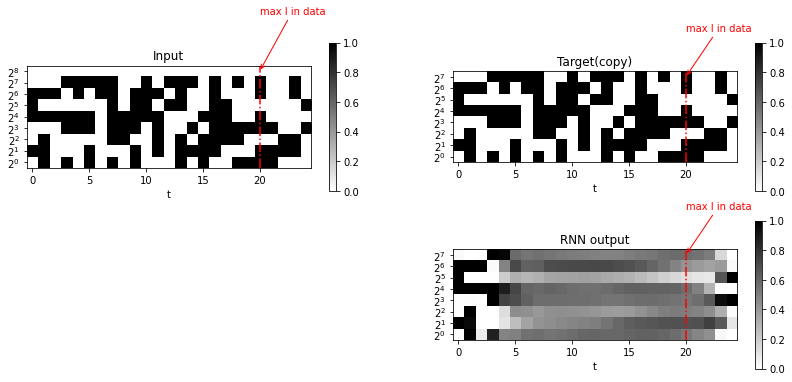

32000-epoch, model saved


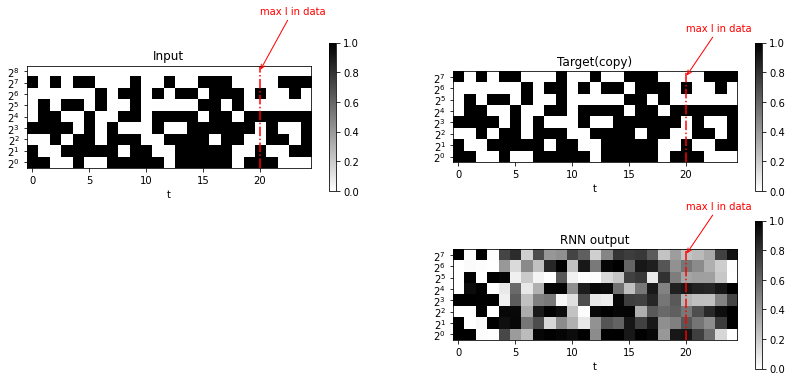

33000-epoch, model saved


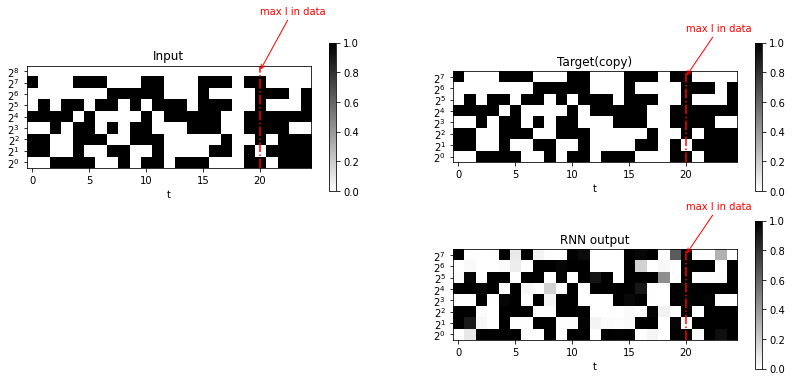

In [24]:
vec_dim, seq_length = 8, 20
data_size, batch_size= 1, 1
f = copy # reverse, sort is also implemented

# NTM cell
N, M = 128, 20
cell = NTMCell(N_memory=N, dim_Memory=M, units=100, shift_read=1, shift_write=1)
# models
model = NaiveModel(vec_dim, cell, batch_size=batch_size)
test_model = NaiveModel(vec_dim, cell, batch_size=1)
# training
train_various_seq(model, test_model, vec_dim, seq_length, f, data_size=data_size, 
                  epoch_size=60000, batch_size=batch_size, savepath='NTM_test_{}'.format(str(f).split(" ")[1]))

#### reverseタスク
reverseは比較的早く汎化する傾向にある気がしました。最速で7000epochsで汎化しました。割愛。

#### sortタスク
sortは難しいのでうまくいきませんでしたが、訓練プロセスを見ると`copy`や`reverse`のように時系列のはじめと終わりを始めに覚えようとせず、各２進数の高次の桁から覚えようとしている様子が見て取れて面白かったので紹介します：

1500-epoch, model saved


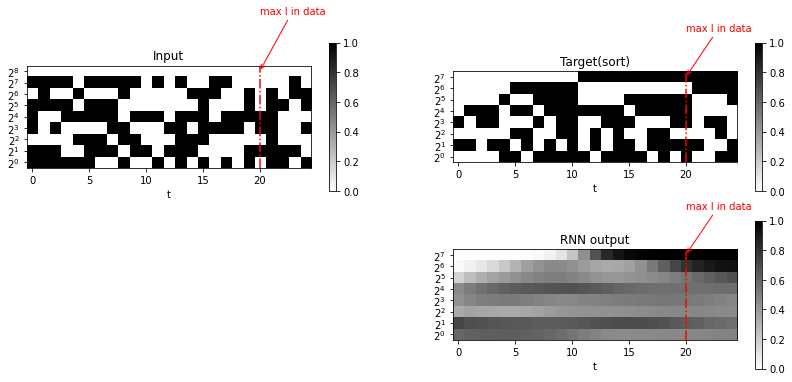

10000-epoch, model saved


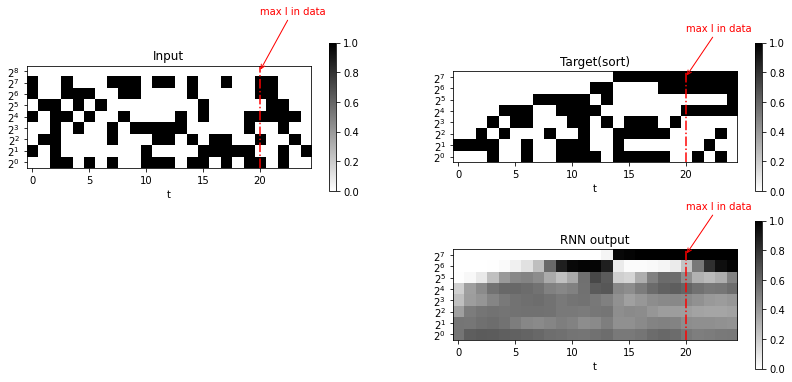

99000-epoch, model saved


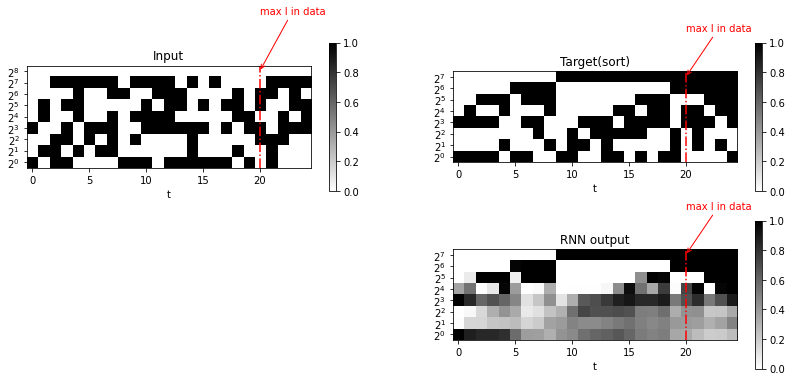

In [19]:
vec_dim, seq_length = 8, 20
data_size, batch_size= 1, 1
f = sort # reverse, sort is also implemented

# NTM cell
N, M = 128, 20
cell = NTMCell(N_memory=N, dim_Memory=M, units=100, shift_read=N//2, shift_write=1)
# models
model = NaiveModel(vec_dim, cell, batch_size=batch_size)
test_model = NaiveModel(vec_dim, cell, batch_size=1)
# training
train_various_seq(model, test_model, vec_dim, seq_length, f, data_size=data_size, 
                  epoch_size=100000, batch_size=batch_size, savepath='NTM_test_{}'.format(str(f).split(" ")[1]))

論文によると`sort`はヘッドの数を増やして、メモリ操作の統計を上げると上手くいくようです。任意数のヘッドにはここでは対応してませんが、書き換えることも可能かと思います。

#### データより長い時系列でのアルゴリズム処理
テストと同時に、メモリスロットの番号でどれが読まれているかも見ると、NTMがうまく動いているかモニターできて良いです。


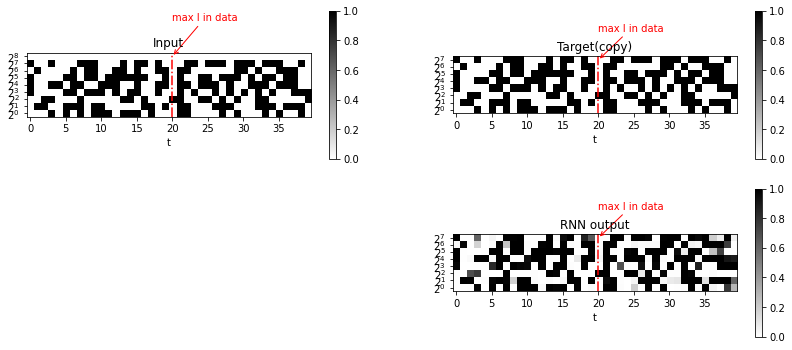

encode w (r, w) : [(105, 101), (26, 100), (127, 101), (6, 102), (12, 103), (77, 104), (6, 105), (126, 106), (126, 107), (126, 108), (12, 109), (12, 110), (77, 111), (126, 112), (126, 113), (6, 114), (126, 115), (126, 116), (77, 117), (77, 118), (77, 119), (126, 120), (126, 121), (77, 122), (77, 123), (77, 124), (126, 125), (126, 126), (77, 127), (77, 0), (77, 1), (77, 2), (77, 3), (77, 4), (77, 5), (77, 6), (77, 7), (77, 8), (54, 9), (77, 10)]
decode w (r, w): [(102, 11), (102, 10), (103, 9), (104, 9), (105, 9), (106, 77), (107, 44), (108, 59), (109, 89), (110, 55), (111, 102), (112, 50), (113, 89), (114, 101), (115, 59), (116, 76), (117, 101), (118, 48), (119, 10), (120, 102), (121, 121), (122, 101), (123, 100), (124, 10), (125, 121), (126, 121), (127, 1), (0, 101), (1, 76), (2, 88), (3, 10), (4, 10), (5, 1), (6, 100), (7, 100), (8, 10), (9, 10), (8, 10), (9, 10), (8, 9)]


In [20]:
f = copy
test_model = NaiveModel(vec_dim, cell, batch_size=1)
test_model.load_weights('NTM_test_{}'.format(str(f).split(" ")[1]))
X = tf.constant([random_X(seq_length+20, vec_dim)], dtype=tf.float32)
test(X, test_model, f=f, given_seq_length=seq_length, bin=False, threshold=0.5, w=True, show=True)

この`copy`の場合は、encode の際にメモリスロット `101, 100, 101, 102, 103, ...` と書き込み(w)にいっており、decodeの際 `102, 102, 103, 104, 105, ...` と読み込み(r)に行っているのがわかります。encodeの際に書き込んだ順に読みに行くというのは`copy`の実装にまさしく必要なことです。これはコピーするアルゴリズムをNTMが自身で**データだけ見て実装した** ということになります。

### 関連する話題
DeepMindによりNTMを更に洗練した**微分可能ニューラルコンピューター(Differentiable Neural Computer, DNC)** （[Graves, A., Wayne, G., Reynolds, M. et al.](https://www.nature.com/articles/nature20101)）が提案され、このアーキテクチャを使うとパズルや最短路線選択などのより複雑なアルゴリズム的タスクが解けるようになったとのことです。